# How to optimize controls using arbitrary basis functions
**Create optimized controls from superpositions of basis functions**

Boulder Opal exposes a highly flexible [optimization engine](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/run_optimization) for general-purpose optimization.
The controls can be described in terms of optimizable linear combinations from a set of built in or user-defined basis functions, which can greatly reduce the dimensionality of the optimization search space.

In this user guide, you'll learn how to optimize controls using a Fourier basis, a Hann series basis, or define your own custom basis.

## Summary workflow

### 1. Define basis function for signal composition in the graph

Define the graph that creates a signal as a superposition of basis functions with [optimizable coefficients](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Graph/optimization_variable) and use it to define [your system's Hamiltonian](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-controls-in-arbitrary-quantum-systems-using-graphs).
Traditionally, a [randomized Fourier basis](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.190501) is used, although the same technique has also seen success with other bases, for example [Slepian functions](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.062346) or [Hann functions](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.93.012324).

The operations that you can use to build the optimizable signal depend on the basis you want to use:

- The Boulder Opal optimization engine provides a convenience graph operation, `graph.real_fourier_pwc_signal`, for creating optimizable signals in a Fourier basis, suitable for use in a **c**hopped **ra**ndom **b**asis (CRAB) optimization.

- The [`signals` attribute](https://docs.q-ctrl.com/boulder-opal/topics/libraries-of-signals-for-boulder-opal) of a graph object provides convenience operations to create optimizable signals in a Hann series basis, as either piecewise-constant functions (`graph.signals.hann_series_pwc`) or as a sampleable function (`graph.signals.hann_series_stf`).
These operations take some potentially optimizable `coefficients`, allowing you to easily create an optimizable signal in a Hann series basis.

- You can also define a custom basis using the [library of graph operations](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes).
In particular, you can create an analytical pulse by creating a node with the `graph.identity_stf` operation, which returns an STF representing the function $f(t) = t$, and then apply [arithmetic](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes#arithmetic) and [mathematical](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes#basic-mathematical-functions) operations to it in order to generate more complex functions.

### 2. Run graph-based optimization

With the graph object created, you can run an optimization using the `boulderopal.run_optimization` function, providing the graph, the cost node, and the desired output nodes.
The function returns the results of the optimization.

## Example: Fourier-basis optimization on a qutrit

In this example, we perform a CRAB optimization (in the Fourier basis) for a robust single qubit Hadamard gate of a qutrit system while [minimizing leakage out of the computational subspace](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-create-leakage-robust-single-qubit-gates), using [Hann window functions](https://en.wikipedia.org/wiki/Hann_function).

The system is described by the following Hamiltonian:
$$
H(t) = \frac{\chi}{2} (a^\dagger)^2 a^2 + (1+\beta(t)) \left(\gamma(t) a + \gamma^*(t) a^\dagger \right) ,
$$
where $\chi$ is the anharmonicity, $\gamma(t)$ is a complex time-dependent pulse, $\beta(t)$ is a small, slowly-varying stochastic amplitude noise process, and $a = |0 \rangle \langle 1 | + \sqrt{2} |1 \rangle \langle 2 |$.
We will parametrize the optimizable pulses, $\gamma(t)$, as a sum of Fourier components.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import qctrlvisualizer as qv
import boulderopal as bo

In [2]:
# Define target and projector matrices.
hadamard = np.array([[1.0, 1.0, 0], [1.0, -1.0, 0], [0, 0, np.sqrt(2)]]) / np.sqrt(2)
qubit_projector = np.diag([1.0, 1.0, 0.0])

# Define physical constraints.
chi = 2 * np.pi * -300e6  # Hz
segment_count = 200
duration = 100e-9  # s
gamma_max = 2 * np.pi * 30e6  # Hz


def create_infidelity(graph, gamma):
    """
    Define a qutrit Hamiltonian with a drive control given by the input gamma
    and calculate the infidelity with respect to the target operation.
    """
    # Define standard matrices.
    a = graph.annihilation_operator(3)
    ada = graph.number_operator(3)

    # Create Hamiltonian.
    anharmonicity = (ada @ ada - ada) * chi / 2
    drive = graph.hermitian_part(2 * gamma * a)
    hamiltonian = anharmonicity + drive

    # Create target operator in the qubit subspace
    target_operator = graph.target(
        hadamard.dot(qubit_projector), filter_function_projector=qubit_projector
    )

    # Create infidelity
    infidelity = graph.infidelity_pwc(
        hamiltonian=hamiltonian,
        target=target_operator,
        noise_operators=[drive],
        name="infidelity",
    )

Your task (action_id="1828723") has started.
Your task (action_id="1828723") has completed.

Optimized cost: 5.799e-07


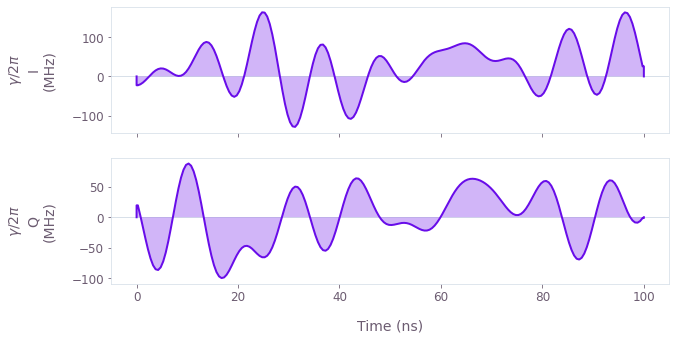

In [3]:
# Number of Fourier terms in superposition.
coefficient_count = 10

# Create optimization graph object.
graph = bo.Graph()

# Create gamma(t) signal in Fourier basis. To demonstrate the full
# flexibility, we show how to use both randomized and optimizable
# basis elements. Elements with fixed frequencies may be chosen too.
gamma_i = graph.real_fourier_pwc_signal(
    duration=duration,
    segment_count=segment_count,
    randomized_frequency_count=coefficient_count,
)
gamma_q = graph.real_fourier_pwc_signal(
    duration=duration,
    segment_count=segment_count,
    optimizable_frequency_count=coefficient_count,
)
gamma = gamma_max * (gamma_i + 1j * gamma_q)
gamma.name = r"$\gamma$"

# Build the rest of the graph.
create_infidelity(graph, gamma)

# Run the optimization
optimization_result = bo.run_optimization(
    cost_node_name="infidelity",
    output_node_names=[r"$\gamma$"],
    graph=graph,
    optimization_count=4,
)

print(f"\nOptimized cost: {optimization_result['cost']:.3e}")
qv.plot_controls(optimization_result["output"], smooth=True, polar=False)

## Example: Robust optimization on a qutrit using Hann window functions

In this example, we optimize the same gate as in the previous example, but parametrizing the optimizable pulse using [Hann window functions](https://en.wikipedia.org/wiki/Hann_function).
The signal $\gamma(t) = \gamma_I(t) + i \gamma_Q(t)$ is then expanded as
$$
\gamma_{I(Q)}(t) = \sum_{n=1}^N{\frac{c^{I(Q)}_n}{2} \left[1-\cos\left(\frac{2\pi nt}{\tau_g}\right) \right]},
$$
where $c^{I(Q)}_n$ are the different real-valued coefficients describing the parametrization and $\tau_g$ is the gate duration. 
This is a good choice for implementation in bandwidth-limited hardware as it is composed of smooth functions that go to zero at the edges. 

Your task (action_id="1828724") has started.
Your task (action_id="1828724") has completed.

Optimized cost: 1.759e-04


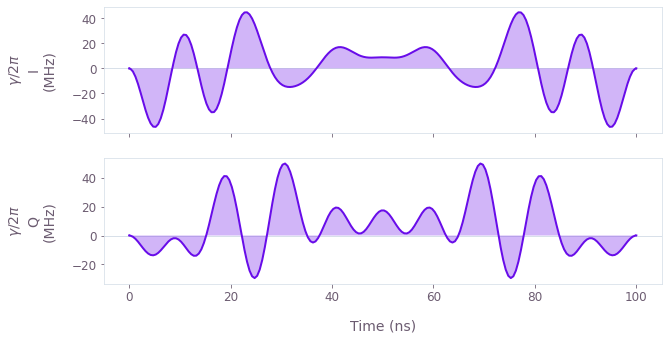

In [4]:
# Number of terms in Hann superposition.
coefficient_count = 10

# Create optimization graph object.
graph = bo.Graph()

# Define the coefficients of the Hann functions for optimization.
hann_coefficients_i = graph.optimization_variable(
    coefficient_count, lower_bound=-1, upper_bound=1
)
hann_coefficients_q = graph.optimization_variable(
    coefficient_count, lower_bound=-1, upper_bound=1
)
hann_coefficients = gamma_max * (hann_coefficients_i + 1j * hann_coefficients_q)

# Create gamma(t) signal in Hann function basis.
gamma = graph.signals.hann_series_pwc(
    duration=duration,
    segment_count=segment_count,
    coefficients=hann_coefficients,
    name=r"$\gamma$",
)

# Build the rest of the graph.
create_infidelity(graph, gamma)

# Run the optimization and retrieve results.
optimization_result = bo.run_optimization(
    cost_node_name="infidelity",
    output_node_names=r"$\gamma$",
    graph=graph,
    optimization_count=4,
)

print(f"\nOptimized cost: {optimization_result['cost']:.3e}")
qv.plot_controls(optimization_result["output"], smooth=True, polar=False)

## Example: Robust optimization on a qutrit using a custom function superposition

In this example, we optimize the same dynamics as in the previous examples, but with pulses parametrized as a superposition of [Lorentz functions](https://en.wikipedia.org/wiki/Cauchy_distribution).
Then, the real and imaginary parts of the optimizable pulse, $\gamma(t) = \gamma_I(t) + i \gamma_Q(t)$, are given by
$$
\gamma_{I(Q)}(t) = \sum_{n=1}^N c^{I(Q)}_n \frac{\sigma^2}{(t - t_n)^2 + \sigma^2} ,
$$
where $c^{I(Q)}_n$ are the different real-valued coefficients describing the parametrization, $\{t_n\}$ are the centers of the Lorentz functions, and $\sigma$ is their width.
This is a good choice for implementation in bandwidth-limited hardware as it is composed of smooth functions that go to zero away from the choice of centers $\{t_n\}$.

Note that you can create a wide variety of analytical functions and superpositions using the different [mathematical and arithmetic graph operations](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes#basic-mathematical-functions).

In [5]:
# Define the function to generate the pulse components.
def custom_optimizable_superposition(graph, duration, coefficient_count, name):
    """
    Create an STF optimizable superposition of Lorentzian functions.

    Parameters
    ----------
    graph : The graph where the signal will belong.
    duration : The duration of the signal.
    coefficient_count : The number of terms in the superposition.
    name : The name of the Tensor node with the optimizable coefficients.

    Returns
    -------
    Stf
        An optimizable superposition of Lorentzian functions.
    """

    # Define optimizable coefficients.
    coefficients = graph.optimization_variable(
        coefficient_count, lower_bound=-1, upper_bound=1, name=name
    )

    # Define Lorentz function parameters.
    width = 0.1 * duration
    centers = np.linspace(0.3, 0.7, coefficient_count) * duration

    # Create Lorentz function superposition.
    time = graph.identity_stf()
    return graph.stf_sum(
        [
            coefficients[index] * width**2 / ((time - center) ** 2 + width**2)
            for index, center in zip(range(coefficient_count), centers)
        ]
    )

Your task (action_id="1828725") has started.
Your task (action_id="1828725") has completed.

Optimized cost: 8.332e-05
Optimized coefficients:
	I: [ 7.927e+07  3.302e+07 -1.078e+08 -5.857e+07  1.337e+08]
	Q: [-1.385e+08  7.739e+07  1.745e+08 -9.236e+07 -5.986e+07]


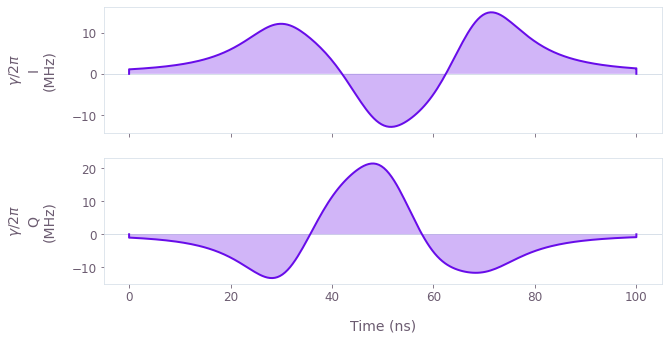

In [6]:
# Number of terms in superposition.
coefficient_count = 5

# Create optimization graph object.
graph = bo.Graph()

# Create gamma(t) signal using custom basis.
gamma_i = custom_optimizable_superposition(
    graph, duration, coefficient_count, name="coef_i"
)
gamma_q = custom_optimizable_superposition(
    graph, duration, coefficient_count, name="coef_q"
)
gamma_stf = gamma_max * (gamma_i + 1j * gamma_q)

# Discretize gamma into PWC.
gamma = graph.discretize_stf(
    stf=gamma_stf, duration=duration, segment_count=segment_count, name=r"$\gamma$"
)

# Build the rest of the graph.
create_infidelity(graph, gamma)

# Run the optimization.
optimization_result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=[r"$\gamma$", "coef_i", "coef_q"],
    optimization_count=4,
)

# Retrieve results and plot optimized pulse.
coefficients_i = gamma_max * optimization_result["output"].pop("coef_i")["value"]
coefficients_q = gamma_max * optimization_result["output"].pop("coef_q")["value"]

print(f"\nOptimized cost: {optimization_result['cost']:.3e}")

print("Optimized coefficients:")
np.set_printoptions(precision=3)
print("\tI:", coefficients_i)
print("\tQ:", coefficients_q)

qv.plot_controls(optimization_result["output"], smooth=True, polar=False)